In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report
import sys
import pandas as pd
import shap

with open("features/features_packed.csv", "r") as f:
  line = f.readline()
  feature_names = line.split(",")
  feature_names.pop(0)

packed = pd.read_csv("features/features_packed.csv")
notpacked = pd.read_csv("features/features_notpacked.csv")
packed1 = pd.read_csv("features/static_features_packed.csv")
notpacked1 = pd.read_csv("features/static_features_notpacked.csv")
packed = packed.merge(packed1[["name"]], on='name')
notpacked = notpacked.merge(notpacked1[["name"]], on='name')
X = pd.concat([packed,notpacked], ignore_index = True)
names = X.loc[:,"name"]
X = X.drop(["name"], axis = 1)
y = np.append(np.ones(len(packed)),np.zeros(len(notpacked)))


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [35]:
name = "wild"
data = pd.read_csv("features/features_" + name + ".csv")
labels = pd.read_csv("labels/labels_" + name + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

y_test_wild = data.loc[:,"label"]
X_test_wild = data.drop(["name","label"], axis = 1)

name2 = "new"
data = pd.read_csv("features/features_" + name2 + ".csv")
labels = pd.read_csv("labels/labels_" + name2 + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

y_test_new = data.loc[:,"label"]
X_test_new = data.drop(["name","label"], axis = 1)

In [36]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}
dt = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=dt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model1 = search.best_estimator_
y_pred = model1.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2} with a score of 0.99167 in training and a score of 0.99545 in testing
The F1-score is 0.99732
The balance accuracy is 0.98920
The precision is 0.99643
The recall is 0.99821
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       101
         1.0       1.00      1.00      1.00       559

    accuracy                           1.00       660
   macro avg       0.99      0.99      0.99       660
weighted avg       1.00      1.00      1.00       660



In [37]:
y_pred_wild = model1.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_new = model1.predict(X_test_new)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_new,y_pred_new))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_new,y_pred_new))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_new,y_pred_new))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_new,y_pred_new))
)
print(classification_report(y_test_new,y_pred_new))

The F1-score is 0.54553
The balance accuracy is 0.66932
The precision is 0.98420
The recall is 0.37735
              precision    recall  f1-score   support

       False       0.19      0.96      0.32       775
        True       0.98      0.38      0.55      4953

    accuracy                           0.46      5728
   macro avg       0.59      0.67      0.43      5728
weighted avg       0.88      0.46      0.52      5728

The F1-score is 0.63717
The balance accuracy is 0.72696
The precision is 0.96000
The recall is 0.47682
              precision    recall  f1-score   support

       False       0.62      0.98      0.76       131
        True       0.96      0.48      0.64       151

    accuracy                           0.71       282
   macro avg       0.79      0.73      0.70       282
weighted avg       0.80      0.71      0.69       282



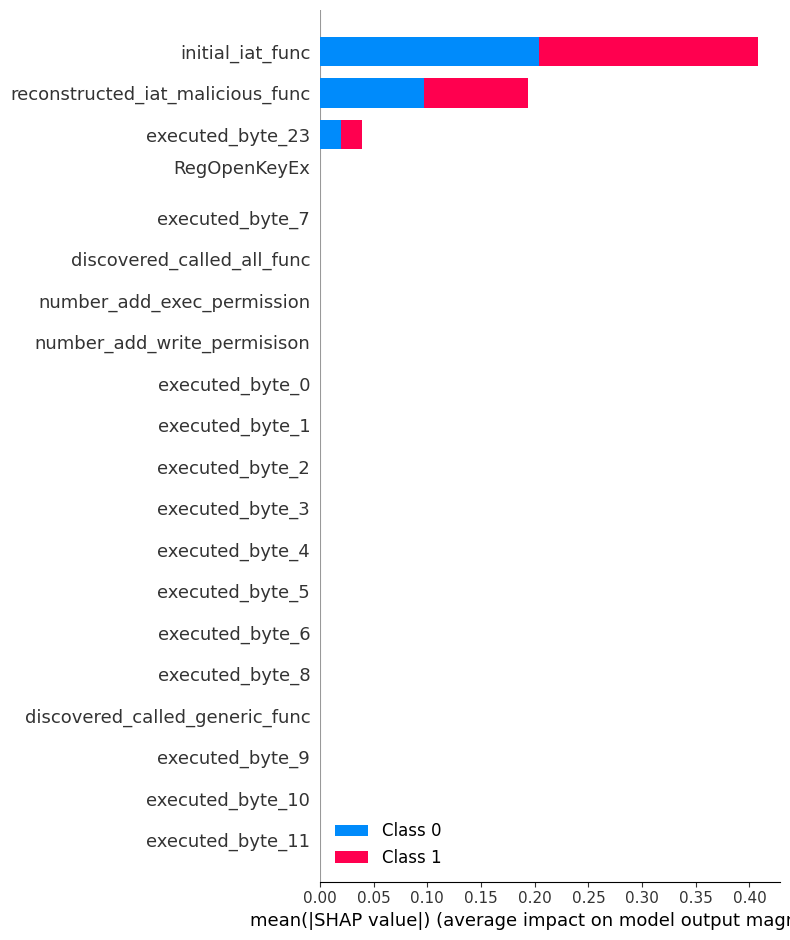

In [38]:
explainer = shap.Explainer(model1)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [39]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
rf = RandomForestClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model2 = search.best_estimator_
y_pred = model2.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 14} with a score of 0.99783 in training and a score of 0.99697 in testing
The F1-score is 0.99821
The balance accuracy is 0.99010
The precision is 0.99643
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       101
         1.0       1.00      1.00      1.00       559

    accuracy                           1.00       660
   macro avg       1.00      0.99      0.99       660
weighted avg       1.00      1.00      1.00       660



In [40]:
y_pred_wild = model2.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_new = model2.predict(X_test_new)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_new,y_pred_new))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_new,y_pred_new))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_new,y_pred_new))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_new,y_pred_new))
)
print(classification_report(y_test_new,y_pred_new))

The F1-score is 0.55735
The balance accuracy is 0.66892
The precision is 0.97969
The recall is 0.38946
              precision    recall  f1-score   support

       False       0.20      0.95      0.32       775
        True       0.98      0.39      0.56      4953

    accuracy                           0.47      5728
   macro avg       0.59      0.67      0.44      5728
weighted avg       0.87      0.47      0.53      5728

The F1-score is 0.57143
The balance accuracy is 0.69003
The precision is 0.93939
The recall is 0.41060
              precision    recall  f1-score   support

       False       0.59      0.97      0.73       131
        True       0.94      0.41      0.57       151

    accuracy                           0.67       282
   macro avg       0.76      0.69      0.65       282
weighted avg       0.78      0.67      0.65       282



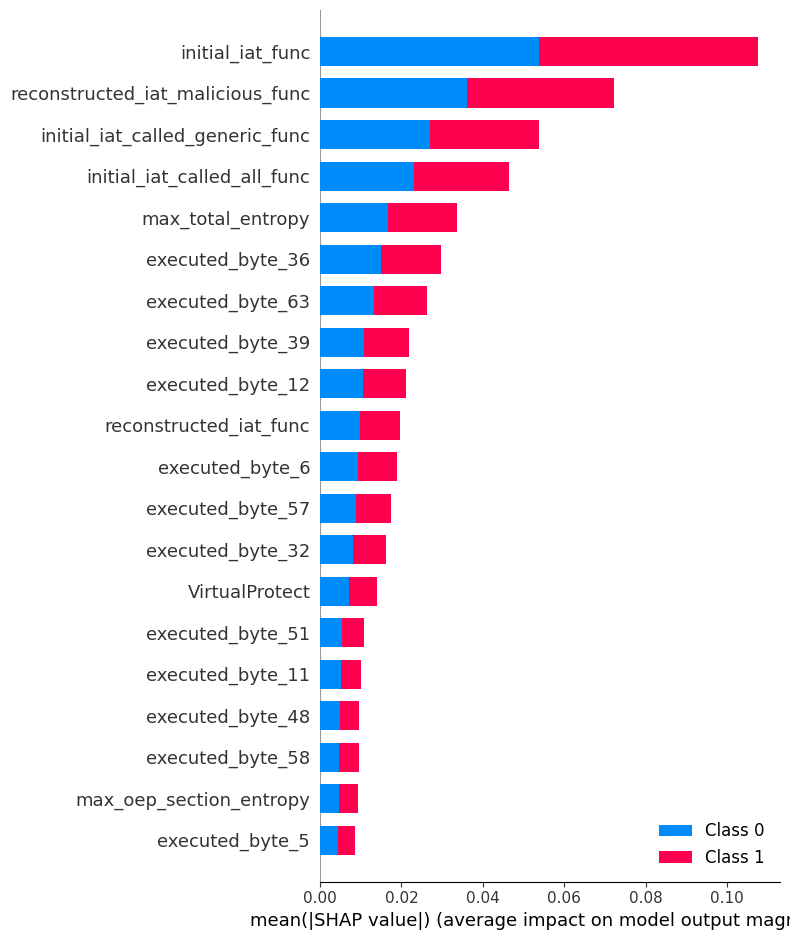

In [41]:
explainer = shap.Explainer(model2)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
param_grid = {"criterion":["friedman_mse","squared_error"],"loss": ["log_loss","exponential"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
gbdt = GradientBoostingClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model3 = search.best_estimator_
y_pred = model3.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

In [ ]:
explainer = shap.Explainer(model3)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean3.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [42]:
with open("features/static_features_packed.csv", "r") as f:
  line = f.readline()
  feature_names = line.split(",")
  feature_names.pop(0)

packed1 = pd.read_csv("features/features_packed.csv")
notpacked1 = pd.read_csv("features/features_notpacked.csv")
packed = pd.read_csv("features/static_features_packed.csv")
notpacked = pd.read_csv("features/static_features_notpacked.csv")
packed = packed.merge(packed1[["name"]], on='name')
notpacked = notpacked.merge(notpacked1[["name"]], on='name')
X = pd.concat([packed,notpacked], ignore_index = True)
names = X.loc[:,"name"]
X = X.drop(["name"], axis = 1)
y = np.append(np.ones(len(packed)),np.zeros(len(notpacked)))


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [43]:
data = pd.read_csv("features/features_" + name + ".csv")
labels = pd.read_csv("labels/labels_" + name + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')
data_static = pd.read_csv("features/static_features_" + name + ".csv")
data_static = data_static.merge(data[["name","label"]], on='name')
names = data_static.loc[:,"name"]
y_test_wild = data_static.loc[:,"label"]
X_test_wild = data_static.drop(["name", "label"], axis = 1)

data = pd.read_csv("features/features_" + name2 + ".csv")
labels = pd.read_csv("labels/labels_" + name2 + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')
data_static = pd.read_csv("features/static_features_" + name2 + ".csv")
data_static = data_static.merge(data[["name","label"]], on='name')
names = data_static.loc[:,"name"]
y_test_new = data_static.loc[:,"label"]
X_test_new = data_static.drop(["name", "label"], axis = 1)

In [44]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}
dt = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=dt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model4 = search.best_estimator_
y_pred = model4.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2} with a score of 0.99092 in training and a score of 0.99697 in testing
The F1-score is 0.99821
The balance accuracy is 0.99010
The precision is 0.99643
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       101
         1.0       1.00      1.00      1.00       559

    accuracy                           1.00       660
   macro avg       1.00      0.99      0.99       660
weighted avg       1.00      1.00      1.00       660



In [45]:
y_pred_wild = model4.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))


y_pred_new = model4.predict(X_test_new)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_new,y_pred_new))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_new,y_pred_new))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_new,y_pred_new))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_new,y_pred_new))
)
print(classification_report(y_test_new,y_pred_new))

The F1-score is 0.53735
The balance accuracy is 0.67153
The precision is 0.98917
The recall is 0.36887
              precision    recall  f1-score   support

       False       0.19      0.97      0.32       775
        True       0.99      0.37      0.54      4953

    accuracy                           0.45      5728
   macro avg       0.59      0.67      0.43      5728
weighted avg       0.88      0.45      0.51      5728

The F1-score is 0.45128
The balance accuracy is 0.64570
The precision is 1.00000
The recall is 0.29139
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       131
        True       1.00      0.29      0.45       151

    accuracy                           0.62       282
   macro avg       0.78      0.65      0.58       282
weighted avg       0.79      0.62      0.57       282



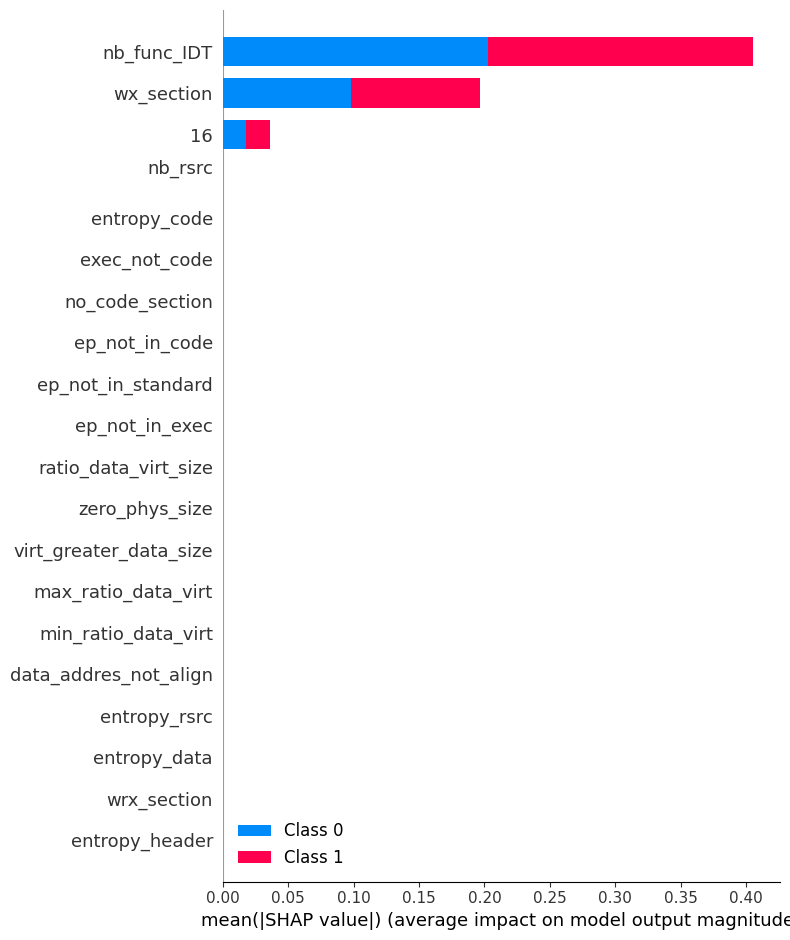

In [46]:
explainer = shap.Explainer(model4)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean4.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [47]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
rf = RandomForestClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model5 = search.best_estimator_
y_pred = model5.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 22} with a score of 0.99783 in training and a score of 0.99545 in testing
The F1-score is 0.99732
The balance accuracy is 0.98515
The precision is 0.99466
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       101
         1.0       0.99      1.00      1.00       559

    accuracy                           1.00       660
   macro avg       1.00      0.99      0.99       660
weighted avg       1.00      1.00      1.00       660



In [48]:
y_pred_wild = model5.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_new = model5.predict(X_test_new)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_new,y_pred_new))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_new,y_pred_new))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_new,y_pred_new))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_new,y_pred_new))
)
print(classification_report(y_test_new,y_pred_new))

The F1-score is 0.56999
The balance accuracy is 0.69204
The precision is 0.99397
The recall is 0.39956
              precision    recall  f1-score   support

       False       0.20      0.98      0.34       775
        True       0.99      0.40      0.57      4953

    accuracy                           0.48      5728
   macro avg       0.60      0.69      0.45      5728
weighted avg       0.89      0.48      0.54      5728

The F1-score is 0.54808
The balance accuracy is 0.68874
The precision is 1.00000
The recall is 0.37748
              precision    recall  f1-score   support

       False       0.58      1.00      0.74       131
        True       1.00      0.38      0.55       151

    accuracy                           0.67       282
   macro avg       0.79      0.69      0.64       282
weighted avg       0.81      0.67      0.64       282



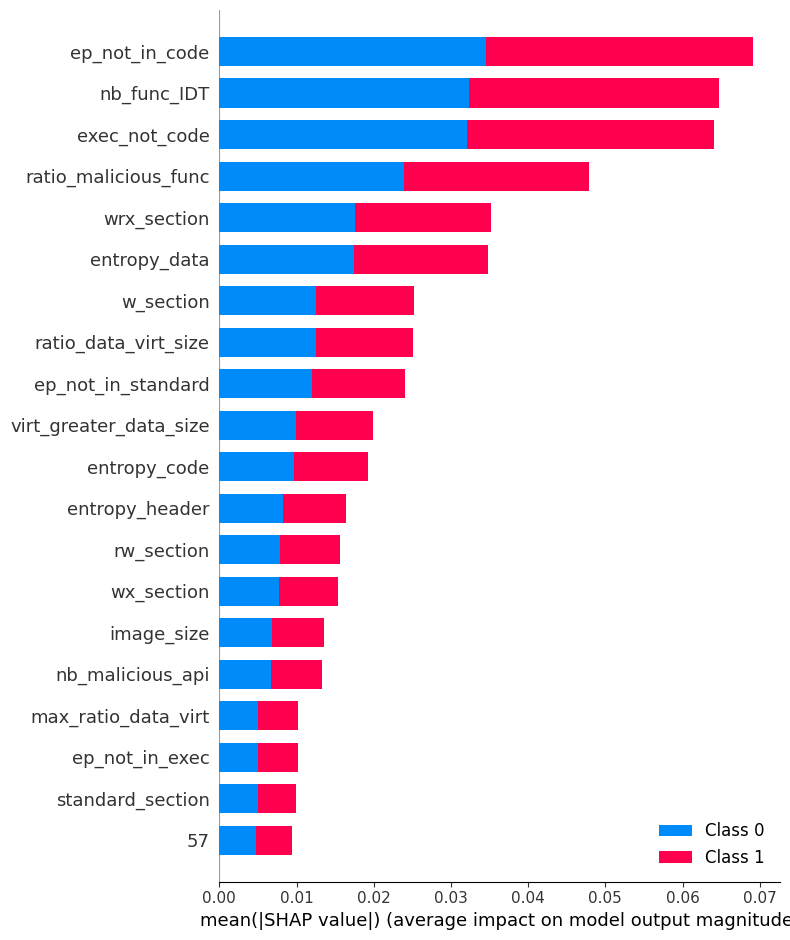

In [49]:
explainer = shap.Explainer(model5)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean5.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
param_grid = {"criterion":["friedman_mse","squared_error"],"loss": ["log_loss","exponential"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
gbdt = GradientBoostingClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model6 = search.best_estimator_
y_pred = model6.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

In [ ]:
explainer = shap.Explainer(model6)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean6.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [50]:
with open("features/static_features_packed.csv", "r") as f:
  line = f.readline()
  static_feature_names = line.split(",")
  static_feature_names.pop(0)

with open("features/features_packed.csv", "r") as f:
  line = f.readline()
  feature_names = line.split(",")
  feature_names.pop(0)

feature_names = feature_names.append(static_feature_names)

packed = pd.read_csv("features/features_packed.csv")
packed_static = pd.read_csv("features/static_features_packed.csv")
packed = packed.merge(packed_static, on='name')
notpacked = pd.read_csv("features/features_notpacked.csv")
notpacked_static = pd.read_csv("features/static_features_notpacked.csv")
notpacked = notpacked.merge(notpacked_static, on='name')

X = pd.concat([packed,notpacked], ignore_index = True)
names = X.loc[:,"name"]
X = X.drop(["name"], axis = 1)
y = np.append(np.ones(len(packed)),np.zeros(len(notpacked)))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [51]:
data = pd.read_csv("features/features_" + name + ".csv")
data_static = pd.read_csv("features/static_features_" + name + ".csv")
data = data.merge(data_static, on='name')

labels = pd.read_csv("labels/labels_" + name + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

names = data.loc[:,"name"]
y_test_wild = data.loc[:,"label"]
X_test_wild = data.drop(["name","label"], axis = 1)


data = pd.read_csv("features/features_" + name2 + ".csv")
data_static = pd.read_csv("features/static_features_" + name2 + ".csv")
data = data.merge(data_static, on='name')

labels = pd.read_csv("labels/labels_" + name2 + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

names = data.loc[:,"name"]
y_test_new = data.loc[:,"label"]
X_test_new = data.drop(["name","label"], axis = 1)

In [52]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}
dt = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=dt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model7 = search.best_estimator_
y_pred = model7.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3} with a score of 0.99375 in training and a score of 1.00000 in testing
The F1-score is 1.00000
The balance accuracy is 1.00000
The precision is 1.00000
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       101
         1.0       1.00      1.00      1.00       559

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660



In [53]:
y_pred_wild = model7.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_new = model7.predict(X_test_new)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_new,y_pred_new))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_new,y_pred_new))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_new,y_pred_new))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_new,y_pred_new))
)
print(classification_report(y_test_new,y_pred_new))

The F1-score is 0.61311
The balance accuracy is 0.70423
The precision is 0.98744
The recall is 0.44458
              precision    recall  f1-score   support

       False       0.21      0.96      0.35       775
        True       0.99      0.44      0.61      4953

    accuracy                           0.51      5728
   macro avg       0.60      0.70      0.48      5728
weighted avg       0.88      0.51      0.58      5728

The F1-score is 0.43523
The balance accuracy is 0.63907
The precision is 1.00000
The recall is 0.27815
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       131
        True       1.00      0.28      0.44       151

    accuracy                           0.61       282
   macro avg       0.77      0.64      0.57       282
weighted avg       0.79      0.61      0.56       282



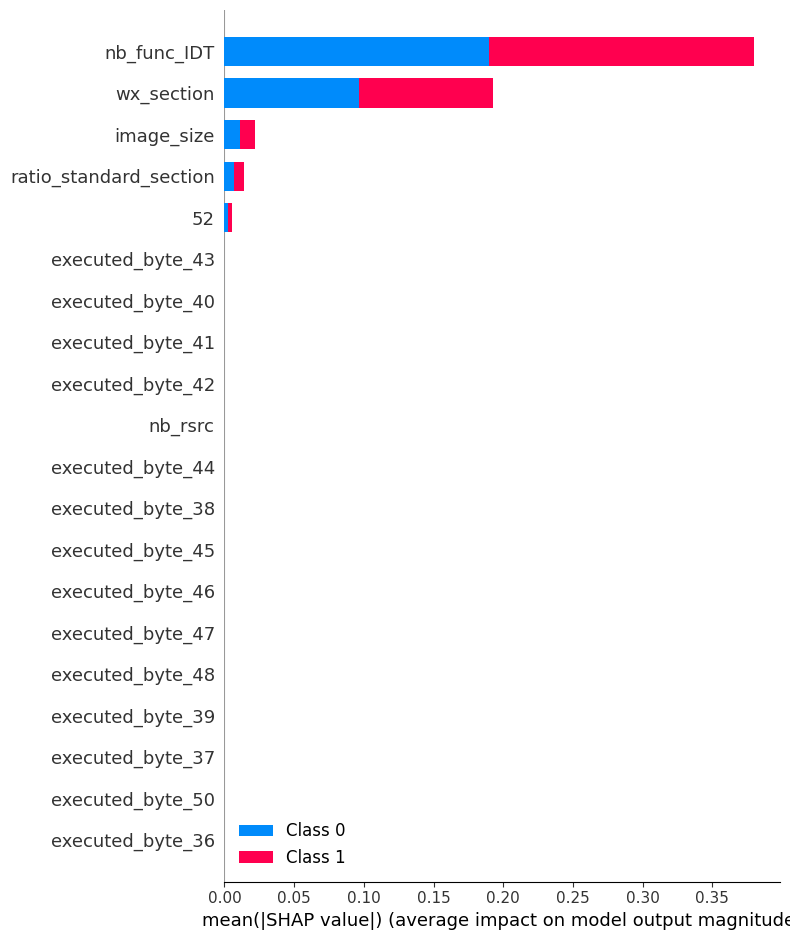

In [54]:
explainer = shap.Explainer(model7)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean7.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [55]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
rf = RandomForestClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model8 = search.best_estimator_
y_pred = model8.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 24} with a score of 1.00000 in training and a score of 0.99848 in testing
The F1-score is 0.99911
The balance accuracy is 0.99505
The precision is 0.99821
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       101
         1.0       1.00      1.00      1.00       559

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660



In [56]:
y_pred_wild = model8.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_new = model8.predict(X_test_new)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_new,y_pred_new))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_new,y_pred_new))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_new,y_pred_new))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_new,y_pred_new))
)
print(classification_report(y_test_new,y_pred_new))

The F1-score is 0.53454
The balance accuracy is 0.68177
The precision is 0.99945
The recall is 0.36483
              precision    recall  f1-score   support

       False       0.20      1.00      0.33       775
        True       1.00      0.36      0.53      4953

    accuracy                           0.45      5728
   macro avg       0.60      0.68      0.43      5728
weighted avg       0.89      0.45      0.51      5728

The F1-score is 0.44330
The balance accuracy is 0.64238
The precision is 1.00000
The recall is 0.28477
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       131
        True       1.00      0.28      0.44       151

    accuracy                           0.62       282
   macro avg       0.77      0.64      0.58       282
weighted avg       0.79      0.62      0.57       282



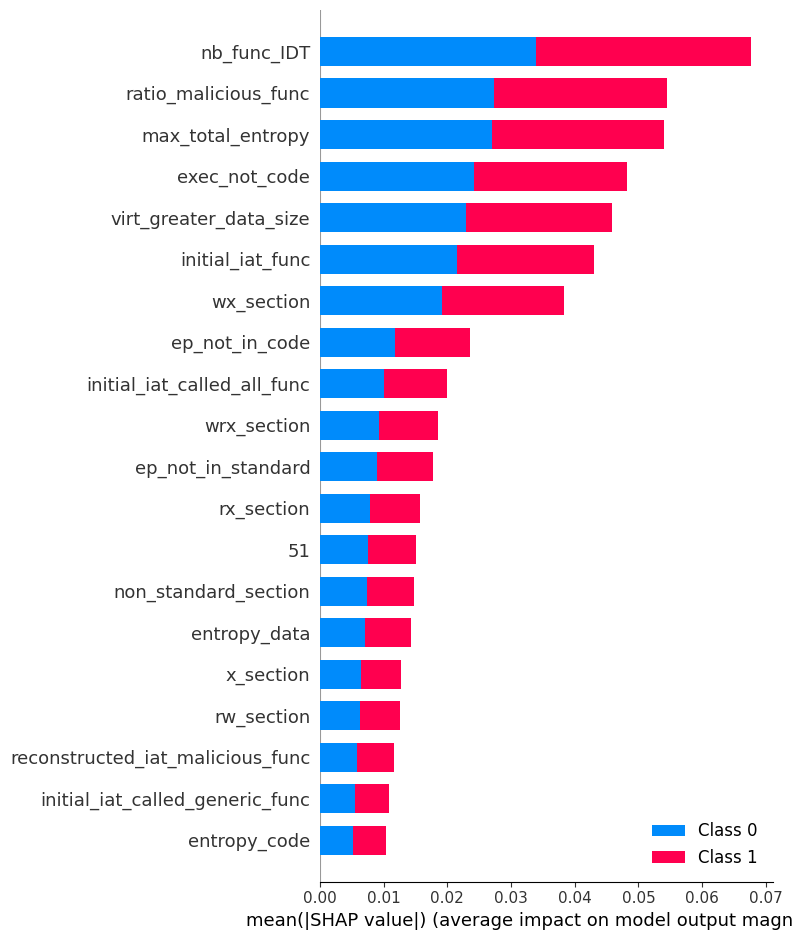

In [57]:
explainer = shap.Explainer(model8)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean8.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
param_grid = {"criterion":["friedman_mse","squared_error"],"loss": ["log_loss","exponential"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
gbdt = GradientBoostingClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model9 = search.best_estimator_
y_pred = model9.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

In [ ]:
explainer = shap.Explainer(model9)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/clean9.pdf", format="pdf", bbox_inches="tight")
plt.show()